# Background

Testing DebtRank implementation in [network_helpers.py](./network_helpers.py) with larger graphs.

# Imports

In [1]:
seed = 1337
from copy import deepcopy
from tqdm.auto import tqdm
import multiprocessing
import warnings
warnings.filterwarnings("ignore")
import scipy as sc
import numpy as np
np.random.seed(seed)
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

# Local helpers for DebtRank
from network_helpers import(
    run_dynamics,
    prepare_data_for_debtrank,
    get_adjacency_matrix,
    debtrank_dynamics,
    debtrank_calculate,
)

# Functions to creata data

In [2]:
def create_exponentially_distributed_network(num_nodes):

    # Grah object
    graph = nx.DiGraph()
    
    # Add nodes to the graph
    graph.add_nodes_from(range(num_nodes))
    
    # Ensure each node is connected to at least one other node
    for node in range(num_nodes):
        if graph.in_degree(node) == 0 and graph.out_degree(node) == 0:
            target = np.random.choice([n for n in range(num_nodes) if n != node])
            graph.add_edge(node, target)
    
    # Add additional edges to create sort of an exponential distribution of
    # connected components
    for node in range(num_nodes):
        if np.random.rand() < 0.1:  # Adjust probability to control sparsity
            target = np.random.choice(
                [
                    n for n in range(num_nodes)
                    if n != node and not graph.has_edge(node, n)
                ]
            )
            graph.add_edge(node, target)
    
    return graph

def define_equity_values(edges, nodes):

    # Come up with weights for the edges representing equity investments
    edges["equity_investment"] = \
        [np.floor(x)+1 for x in np.random.exponential(scale=5, size=len(edges)) * 10]

    # Equitites for target firms
    equity = (
        edges
        .copy()
        .groupby("target")
        .agg(equity=("equity_investment", "sum"))
    )
    equity.index.name = "node_id"

    # Get source-only entities
    nodes_zero_indegree = nodes.index.difference(equity.index)

    # Concat equities
    equity = pd.concat(
        [
            equity,
            pd.DataFrame(
                data={
                    "node_id": nodes_zero_indegree.values,
                    "equity": [
                        np.floor(x)+1
                        for x
                        in np.random.exponential(scale=3, size=len(nodes_zero_indegree)) * 10
                    ]
                }
            )
            .set_index("node_id")
        ]
    )
    equity = equity.sort_index()
    assert np.all(equity.index == nodes.index)

    # Add some jitter to the equitites, so that the total equity is not always
    # fully detemined by the known investments in the network
    def draw_random_jitter(N, p):
        X = np.random.randint(4, 20, N)
        choices = np.random.binomial(1, p, N)
        return choices * X
    equity = equity.add(draw_random_jitter(len(equity), p=0.5), axis=0)

    # Merge nodes with equity values
    nodes = pd.merge(
        nodes,
        equity,
        how="left",
        left_on="node_id",
        right_index=True,
    )
    del equity
    
    return edges, nodes

def print_stats(graph):
    print("# of nodes: {:,.0f}".format(graph.number_of_nodes()))
    print("# of nodes: {:,.0f}".format(graph.number_of_edges()))
    print("Density: {:.2f}".format(nx.density(graph)))
    print("Avg. degree: {:.2f}".format(sum(dict(graph.degree()).values()) / graph.number_of_nodes()))
    print("Degree assort. (out-in): {:.2f}".format(
        nx.degree_assortativity_coefficient(graph, x="out", y="in")))
    print("Degree assort. (in-in): {:.2f}".format(
        nx.degree_assortativity_coefficient(graph, x="in", y="in")))
    print("Degree assort. (out-out): {:.2f}".format(
        nx.degree_assortativity_coefficient(graph, x="out", y="out")))

# Example - Small network

## Create network

# of nodes: 200
# of nodes: 171
Density: 0.00
Avg. degree: 1.71
Degree assort. (out-in): -0.09
Degree assort. (in-in): -0.13
Degree assort. (out-out): -0.01


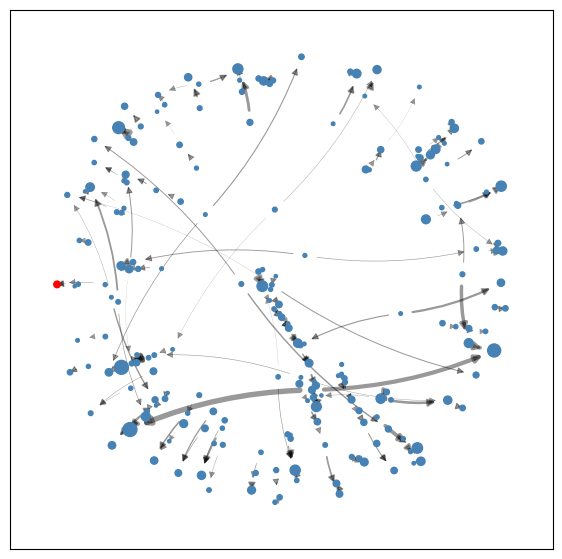

In [3]:
# Create a network
graph = create_exponentially_distributed_network(num_nodes=200)

# Get edges frame
edges = pd.DataFrame(
    graph.edges(data=False),
    columns=["source", "target"],
)

# Get nodes frame
nodes = pd.DataFrame(
    graph.nodes(data=False),
    columns=["node_id"],
)

# Define equity values
edges, nodes = define_equity_values(edges, nodes)

# Assign nodes to be stressed initially
initially_stressed = [93]
nodes["initially_stressed"] = nodes["node_id"].isin(initially_stressed)
nodes["color"] =  np.where(nodes["initially_stressed"], "red", "steelblue")

# Set edges and node attributes in the graph
for name, vals in edges.set_index(["source", "target"]).to_dict().items():
    nx.set_edge_attributes(graph, values=vals, name=name)
for name, vals in nodes.set_index("node_id").to_dict().items():
    nx.set_node_attributes(graph, values=vals, name=name)

# Draw network
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)
pos = nx.spring_layout(graph, seed=seed)
nx.draw_networkx_nodes(
    graph,
    pos,
    node_size=minmax_scale(
        [graph.nodes[node]["equity"] for node in graph.nodes()],
        feature_range=(5, 100),
    ),
    node_color=[graph.nodes[node]["color"] for node in graph.nodes()],
    ax=ax,
)
_ = nx.draw_networkx_edges(
    graph,
    pos,
    connectionstyle="arc3,rad=0.1",
    width=minmax_scale(
        [graph[u][v]["equity_investment"] for u, v in graph.edges()],
        feature_range=(0.1, 4.0),
    ),
    alpha=0.4,
    ax=ax,
)
print_stats(graph)

## Run DebtRank algorithm once from selected initially stressed node(s)

In [4]:
# Prepare
edges_dr, nodes_dr = prepare_data_for_debtrank(edges, nodes)
W, ids = get_adjacency_matrix(edges_dr)

# Run algo
distress = debtrank_dynamics(
    W_in=W,
    ids=ids,
    S_f=initially_stressed,
)
print("DebtRank: {:.3f}".format(debtrank_calculate(distress, nodes_dr)))
distress.query("s!='U'")

DebtRank: 0.008


,h,s,h_init
node_id,,,
2,0.458333,I,0
78,1.000000,I,0
93,1.000000,I,1
120,1.000000,I,0


## Run DebtRank algorithm starting separately from each node

In [5]:
# Prepare
edges_dr, nodes_dr = prepare_data_for_debtrank(edges, nodes)
W, ids = get_adjacency_matrix(edges_dr)

# Run algo
distress = {}
debtranks = {}
for node in tqdm(nodes["node_id"]):
    distress[node] = debtrank_dynamics(
        W_in=W,
        ids=ids,
        S_f=[node],
    )
    debtranks[node] = debtrank_calculate(distress[node], nodes_dr)

  0%|          | 0/200 [00:00<?, ?it/s]

# Example - Big network

## Create network

In [6]:
# Create a network
graph = create_exponentially_distributed_network(num_nodes=5000)

# Get edges frame
edges = pd.DataFrame(
    graph.edges(data=False),
    columns=["source", "target"],
)

# Get nodes frame
nodes = pd.DataFrame(
    graph.nodes(data=False),
    columns=["node_id"],
)

# Define equity values
edges, nodes = define_equity_values(edges, nodes)

# Set edges and node attributes in the graph
for name, vals in edges.set_index(["source", "target"]).to_dict().items():
    nx.set_edge_attributes(graph, values=vals, name=name)
for name, vals in nodes.set_index("node_id").to_dict().items():
    nx.set_node_attributes(graph, values=vals, name=name)

# Print desc stats
print_stats(graph)

# of nodes: 5,000
# of nodes: 3,947
Density: 0.00
Avg. degree: 1.58
Degree assort. (out-in): 0.01
Degree assort. (in-in): -0.04
Degree assort. (out-out): 0.11


## Run DebtRank algorithm starting separately from each node

In [7]:
# Prepare data
edges_dr, nodes_dr = prepare_data_for_debtrank(edges, nodes)
W, ids = get_adjacency_matrix(edges_dr)

In [8]:
%%time
# Run simulation with parallelization
args = [(node, W, ids, nodes_dr) for node in nodes["node_id"]]
with multiprocessing.Pool(processes=3) as pool:
    iterator = pool.imap_unordered(run_dynamics, args)
    results = [x for x in tqdm(iterator, total=len(nodes["node_id"]))]

  0%|          | 0/5000 [00:00<?, ?it/s]

Wall time: 3min 54s
